In [1]:
!mkdir -p "data"


In [4]:
!unzip -qq -o /content/archive.zip -d data/

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


In [6]:
# Выравнивание и нормализация входных изображений
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
   'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# загрузка двух датасетов
data_dir = '/content/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','valid']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['BANDED BROADBILL', 'BIRD OF PARADISE']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


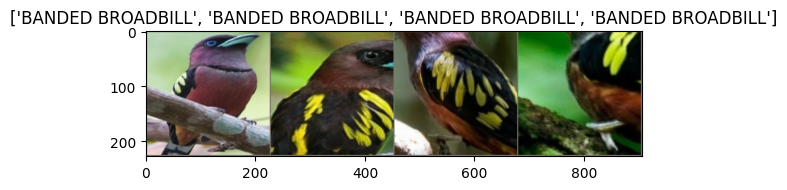

In [8]:
# вывод изображения
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# выводим очередную серию изображений
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features # model_ft.fc -- это слой Linear
model_ft.fc = nn.Linear(num_ftrs, 2) # подменяем оригинальный слой своим

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Будем уменьшать скорость обучения с коэффициентом 0.1 каждые 7 эпох
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3783 Acc: 0.8137
valid Loss: 0.0375 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.3266 Acc: 0.8602
valid Loss: 0.0935 Acc: 0.9000

Epoch 2/24
----------
train Loss: 0.4014 Acc: 0.8820
valid Loss: 0.0060 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3437 Acc: 0.8634
valid Loss: 0.1319 Acc: 0.9000

Epoch 4/24
----------
train Loss: 0.2691 Acc: 0.9006
valid Loss: 0.0124 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2159 Acc: 0.9193
valid Loss: 0.0109 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.2035 Acc: 0.9255
valid Loss: 0.0042 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2026 Acc: 0.9130
valid Loss: 0.0040 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2283 Acc: 0.9130
valid Loss: 0.0201 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.2202 Acc: 0.9130
valid Loss: 0.0125 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2405 Acc: 0.9161
valid Loss: 0.0134 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2197 Acc: 0.9193
valid Loss

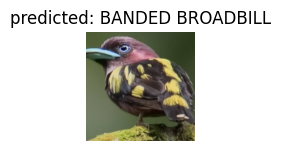

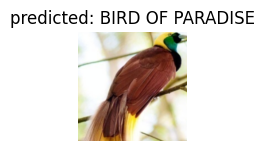

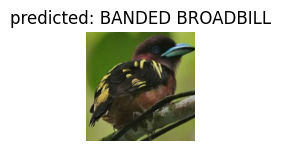

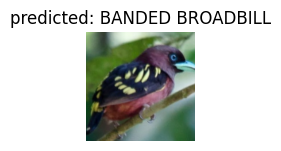

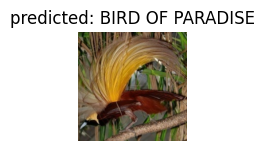

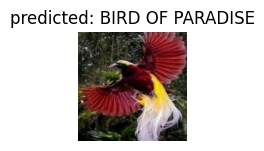

In [16]:
visualize_model(model_ft)

In [17]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [18]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4873 Acc: 0.7516
valid Loss: 0.1639 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.5385 Acc: 0.7733
valid Loss: 0.0241 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.4252 Acc: 0.8168
valid Loss: 0.0405 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.3079 Acc: 0.8789
valid Loss: 0.0095 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.3550 Acc: 0.8416
valid Loss: 0.0051 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.2361 Acc: 0.9037
valid Loss: 0.0054 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.3143 Acc: 0.8602
valid Loss: 0.0060 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.2422 Acc: 0.8944
valid Loss: 0.0063 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.2051 Acc: 0.9193
valid Loss: 0.0071 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.3115 Acc: 0.8789
valid Loss: 0.0088 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2791 Acc: 0.8789
valid Loss: 0.0103 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.2262 Acc: 0.9099
valid Loss

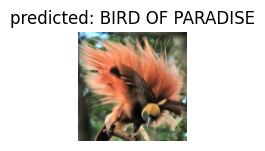

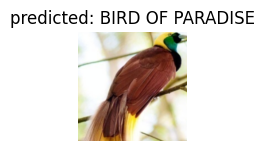

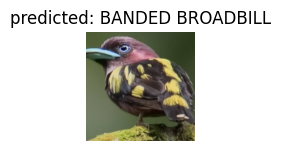

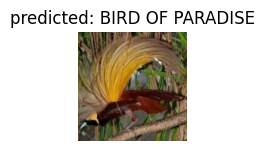

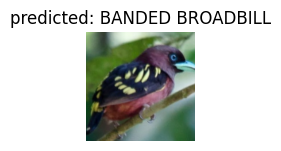

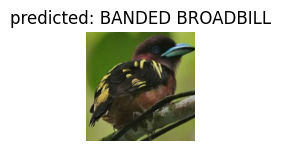

In [19]:
visualize_model(model_conv)

plt.ioff()
plt.show()